# Creating, Evaluating, and Deploying a Text Classification Model

## Introduction

In this notebook, we will demonstrate Microsoft Fabric end-to-end data science workflow for a text classification model. The scenario is to use word2vec and logistic regression on Spark to determine a book's genre from the British Library book dataset solely based on the book's title.

The summary of the main steps we take in this notebook are as following:

1. Install custom libraries
2. Load and process the data
3. Understand the data using exploratory data analysis
4. Train a machine learning model using word2vec and logistic regression
5. Load the machine learning model for scoring and make predictions

## Prerequisites
- Have a lakehouse added to this notebook. We will be downloading data from a public blob, and storing that in the lakehouse. 

<mark></mark>
## Step 1: Install Custom Libraries
When developing a machine learning model or doing ad-hoc data analysis, we may need to quickly install a custom library for the Apache Spark session. To do this, we have two approaches. 

1. We can use the in-line installation capabilities (e.g., pip, conda, etc.) to quickly get started with new libraries.
```python
# Use pip to install libraries
%pip install <library name>

# Use conda to install libraries
%conda install <library name>
 
```
2. Alternatively, we can install the required libraries in the workspace. Navigate to the workspace setting as shown below and then click on Library management.

<img style="float: left;" src="https://synapseaisolutionsa.blob.core.windows.net/public/Credit_Card_Fraud_Detection/librarymanagement2.png"  width="45%" height="10%">
<img style="float: left;" src="https://synapseaisolutionsa.blob.core.windows.net/public/Credit_Card_Fraud_Detection/librarymanagement1.png"  width="45%" height="10%"> 


We can then select how to install the required libraries, e.g., add from PyPi, add from .yml file, etc. Since we are using PyPi, we click on `+ Add from PyPi` and then select the desired libraries and their corresponding versions from the drop down and then click on the Apply. This will automatically install all selected libraries in the workspace.

<img src="https://synapseaisolutionsa.blob.core.windows.net/public/Title_Genre_Classification/librarymanagement-wordcloud.png"  width="50%" height="20%">

To build our classification model, we will be using the `wordcloud` library which is used to represent the frequency of words in a text where the size of the word represents its frequency. In order to install `wordcloud`, we will proceed with the first approach in Step 1.

Note that the PySpark kernel will be restarted after `%pip install`, thus we need to install the library before we run any other cells.

In [ ]:
# Install wordcloud for text visualization
%pip install wordcloud

## Step 2: Load and Process the Data

#### Dataset 

The dataset is from the [British Library book dataset](https://huggingface.co/datasets/blbooksgenre) and comprises of metadata about books that have been digitized through collaboration between the British Library and Microsoft. The dataset consists of classifications which were created by humans to indicate whether a book is "fiction" or "non-fiction." Using this dataset, our goal is to train a classification model that determines a book's genre solely based on its title.

|BL record ID|Type of resource|Name|Dates associated with name|Type of name|Role|All names|Title|Variant titles|Series title|Number within series|Country of publication|Place of publication|Publisher|Date of publication|Edition|Physical description|Dewey classification|BL shelfmark|Topics|Genre|Languages|Notes|BL record ID for physical resource|classification_id|user_id|created_at|subject_ids|annotator_date_pub|annotator_normalised_date_pub|annotator_edition_statement|annotator_genre|annotator_FAST_genre_terms|annotator_FAST_subject_terms|annotator_comments|annotator_main_language|annotator_other_languages_summaries|annotator_summaries_language|annotator_translation|annotator_original_language|annotator_publisher|annotator_place_pub|annotator_country|annotator_title|Link to digitised book|annotated|
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|014602826|Monograph|Yearsley, Ann|1753-1806|person||More, Hannah, 1745-1833 [person] ; Yearsley, Ann, 1753-1806 [person]|Poems on several occasions [With a prefatory letter by Hannah More.]||||England|London||1786|Fourth edition MANUSCRIPT note|||Digital Store 11644.d.32|||English||003996603||||||||||||||||||||||False|
|014602830|Monograph|A, T.||person||Oldham, John, 1653-1683 [person] ; A, T. [person]|A Satyr against Vertue. (A poem: supposed to be spoken by a Town-Hector [By John Oldham. The preface signed: T. A.])||||England|London||1679||15 pages (4°)||Digital Store 11602.ee.10. (2.)|||English||000001143||||||||||||||||||||||False|


**By defining below parameters, we can apply this notebook on different datasets easily.**

In [ ]:
IS_CUSTOM_DATA = False  # if True, dataset has to be uploaded manually by user
DATA_FOLDER = "Files/title-genre-classification"
DATA_FILE = "blbooksgenre.csv"

# Data schema
TEXT_COL = "Title"
LABEL_COL = "annotator_genre"
LABELS = ["Fiction", "Non-fiction"]

EXPERIMENT_NAME = "aisample-textclassification"  # MLflow experiment name

StatementMeta(, b868b727-3e52-4d09-a1fe-24b4a84b4a17, 10, Finished, Available)

### Download dataset and Upload to lakehouse

The following code will download a publicly available version of the the dataset and then store it in a Fabric Lakehouse.

**Please add a lakehouse to the notebook before running it. Failure to do so will result in an error.**

Instructions to add a lakehouse to the notebook can be found [here](https://aka.ms/fabric/addlakehouse).

In [ ]:
if not IS_CUSTOM_DATA:
    # Download demo data files into lakehouse if it does not exist
    import os, requests

    remote_url = "https://synapseaisolutionsa.blob.core.windows.net/public/Title_Genre_Classification"
    fname = "blbooksgenre.csv"
    download_path = f"/lakehouse/default/{DATA_FOLDER}/raw"

    if not os.path.exists("/lakehouse/default"):
        # Add a lakehouse if no default lakehouse has been added to the notebook
        # A new notebook will not link to any lakehouse by default
        raise FileNotFoundError(
            "Default lakehouse not found, please add a lakehouse and restart the session."
        )
    os.makedirs(download_path, exist_ok=True)
    if not os.path.exists(f"{download_path}/{fname}"):
        r = requests.get(f"{remote_url}/{fname}", timeout=30)
        with open(f"{download_path}/{fname}", "wb") as f:
            f.write(r.content)
    print("Downloaded demo data files into lakehouse.")

StatementMeta(, b868b727-3e52-4d09-a1fe-24b4a84b4a17, 11, Finished, Available)

Downloaded demo data files into lakehouse.


### Import required libraries

Prior to any processing, we need to import required libraries for Spark and SynapseML. For more information about Spark and SynapseML, you can refer to the following resources: [here](https://spark.apache.org/) for Spark and [here](https://aka.ms/AboutSynapseML) for SynapseML.

In [ ]:
import numpy as np
from itertools import chain

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

import pyspark.sql.functions as F

from pyspark.ml import Pipeline
from pyspark.ml.feature import *
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import (
    BinaryClassificationEvaluator,
    MulticlassClassificationEvaluator,
)

from synapse.ml.stages import ClassBalancer
from synapse.ml.train import ComputeModelStatistics

import mlflow

StatementMeta(, b868b727-3e52-4d09-a1fe-24b4a84b4a17, 12, Finished, Available)

### Define Hyper-Parameters
We will also define some hyper-parameters for model training. **Please only modify these if you have an understanding of each parameter.**

In [ ]:
# Hyper-parameters 
word2vec_size = 128  # the lenght of the vector for each word
min_word_count = 3  # the minimum number of times that a word must appear to be considered
max_iter = 10  # maximum number of training iterations
k_folds = 3  # number of folds for cross-validation

StatementMeta(, b868b727-3e52-4d09-a1fe-24b4a84b4a17, 13, Finished, Available)

We start recording the time it takes to run this notebook.

In [ ]:
# Record the notebook running time
import time

ts = time.time()

StatementMeta(, b868b727-3e52-4d09-a1fe-24b4a84b4a17, 14, Finished, Available)

#### Setup the MLflow experiment tracking

Extending the MLflow autologging capabilities, autologging works by automatically capturing the values of input parameters and output metrics of a machine learning model as it is being trained. This information is then logged to the workspace, where it can be accessed and visualized using the MLflow APIs or the corresponding experiment in the workspace. Further information about how to perform autologging can be found [here](https://aka.ms/fabric-autologging).

In [ ]:
# Setup Mlflow for experiment tracking

mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.autolog(disable=True)  # Disable Mlflow autologging

StatementMeta(, b868b727-3e52-4d09-a1fe-24b4a84b4a17, 15, Finished, Available)

Note that if we want to disable Microsoft Fabric autologging in a notebook session, we can call `mlflow.autolog()` and set `disable=True`.

### Read raw date data from the lakehouse

In [ ]:
raw_df = spark.read.csv(f"{DATA_FOLDER}/raw/{DATA_FILE}", header=True, inferSchema=True)

StatementMeta(, b868b727-3e52-4d09-a1fe-24b4a84b4a17, 16, Finished, Available)

## Step 3: Exploratory Data Analysis

We can explore the dataset using the `display` command to view high-level statistics of the dataset.

In [ ]:
display(raw_df.limit(20))

StatementMeta(, b868b727-3e52-4d09-a1fe-24b4a84b4a17, 17, Finished, Available)

SynapseWidget(Synapse.DataFrame, f270ba09-a380-4101-ae5e-213bcfb6806a)

###  Data Preparation

Data Preparation includes the following steps:

- Cleaning the dataset
- Dealing with dataset imbalance
- Tokekenizing the dataset
- Displaying the wordcloud
- Vectorizing the dataset


We start cleaning the data by removing the duplicates.

In [ ]:
df = (
    raw_df.select([TEXT_COL, LABEL_COL])
    .where(F.col(LABEL_COL).isin(LABELS))
    .dropDuplicates([TEXT_COL])
    .cache()
)

display(df.limit(20))

StatementMeta(, b868b727-3e52-4d09-a1fe-24b4a84b4a17, 18, Finished, Available)

SynapseWidget(Synapse.DataFrame, 60be7928-2b4f-46d2-a540-342b6781fad7)

We then apply the class balancing in order to address any bias.

In [ ]:
# Create an instance of ClassBalancer and set the input column to LABEL_COL
cb = ClassBalancer().setInputCol(LABEL_COL)

# Fit the ClassBalancer instance to the input DataFrame and transform the DataFrame
df = cb.fit(df).transform(df)

# Display the first 20 rows of the transformed DataFrame
display(df.limit(20))

StatementMeta(, b868b727-3e52-4d09-a1fe-24b4a84b4a17, 19, Finished, Available)

SynapseWidget(Synapse.DataFrame, 4518788c-3e8b-4514-808d-51c769b2bcd2)

We tokenize by splitting the paragraphs and sentences into smaller units that can be more easily assigned meaning. We then remove the stopwords in order to improve the performance. Note that stopword removal is one of the most commonly used pre-processing steps in Natural Language Processing (NLP) applications, where the idea is to simply remove the words that occur commonly across all the documents in the corpus. 

In [ ]:
# Text transformer
tokenizer = Tokenizer(inputCol=TEXT_COL, outputCol="tokens")
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")

# Build the pipeline
pipeline = Pipeline(stages=[tokenizer, stopwords_remover])

token_df = pipeline.fit(df).transform(df)

display(token_df.limit(20))

StatementMeta(, b868b727-3e52-4d09-a1fe-24b4a84b4a17, 20, Finished, Available)

SynapseWidget(Synapse.DataFrame, 2a6ca2a8-f54a-4ebc-8892-58f7ff5b4c5d)

In the following, we display the wordcloud for each class.

Note that a wordcloud is a visually prominent presentation of “keywords” that appear frequently in text data. This is effective because the rendering of keywords forms a cloud-like color picture to better capture the main text data at a glance. You can learn more about `wordcloud` [here](https://github.com/amueller/word_cloud).


StatementMeta(, b868b727-3e52-4d09-a1fe-24b4a84b4a17, 21, Finished, Available)

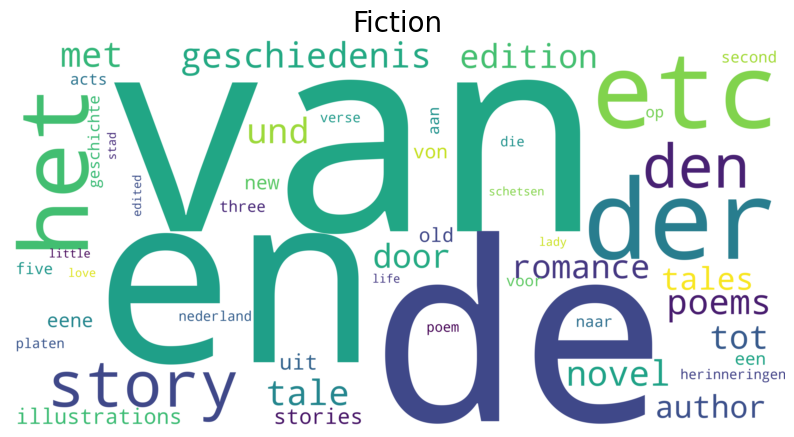

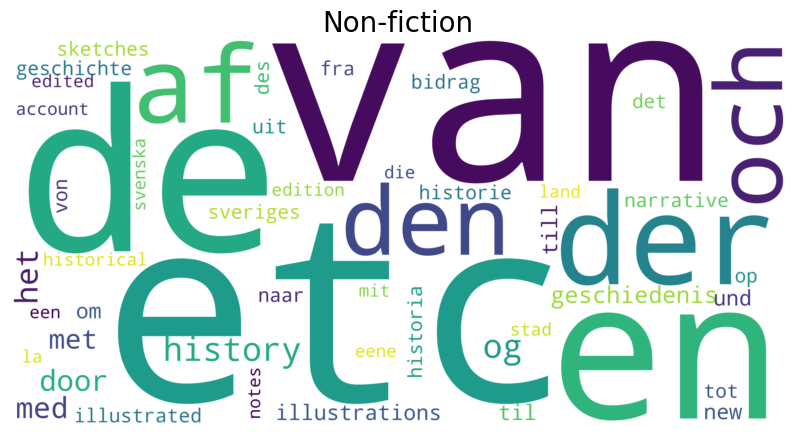

In [ ]:
# WordCloud
for label in LABELS:
    tokens = (
        token_df.where(F.col(LABEL_COL) == label)
        .select(F.explode("filtered_tokens").alias("token"))
        .where(F.col("token").rlike(r"^\w+$"))
    )

    top50_tokens = (
        tokens.groupBy("token").count().orderBy(F.desc("count")).limit(50).collect()
    )

    # Generate a word cloud image
    wordcloud = WordCloud(
        scale=10,
        background_color="white",
        random_state=42,  # Make sure the output is always the same for the same input
    ).generate_from_frequencies(dict(top50_tokens))

    # Display the generated image using matplotlib
    plt.figure(figsize=(10, 10))
    plt.title(label, fontsize=20)
    plt.axis("off")
    plt.imshow(wordcloud, interpolation="bilinear")

Finally, we use `word2vec` to vectorize the text. Note that `word2vec` creates a representation of each word present in our text into a vector. Words used in similar contexts or having semantic relationships are captured effectively through their closeness in the vector space, indicating that similar words will have similar word vectors.

In [ ]:
# Label transformer
label_indexer = StringIndexer(inputCol=LABEL_COL, outputCol="labelIdx")
vectorizer = Word2Vec(
    vectorSize=word2vec_size,
    minCount=min_word_count,
    inputCol="filtered_tokens",
    outputCol="features",
)

# Build the pipeline
pipeline = Pipeline(stages=[label_indexer, vectorizer])
vec_df = (
    pipeline.fit(token_df)
    .transform(token_df)
    .select([TEXT_COL, LABEL_COL, "features", "labelIdx", "weight"])
)

display(vec_df.limit(20))

StatementMeta(, b868b727-3e52-4d09-a1fe-24b4a84b4a17, 22, Finished, Available)

SynapseWidget(Synapse.DataFrame, 01afc127-aa6d-4da6-aee9-0ee82b5848a1)

## Step 4: Model Training and Evaluation

With our data in place, we can now define the model. In this section, we train a logistic regression model to classify the vectorized text.

### Prepare training and test datasets

In [ ]:
# Split the dataset into training and test sets
(train_df, test_df) = vec_df.randomSplit((0.8, 0.2), seed=42)

StatementMeta(, b868b727-3e52-4d09-a1fe-24b4a84b4a17, 23, Finished, Available)

### Model Training and Machine Learning Experiments

A machine learning experiment is the primary unit of organization and control for all related machine learning runs. A run corresponds to a single execution of model code. Machine learning experiment tracking refers to the process of managing all the different experiments and their components, such as parameters, metrics, models and other artifacts and it enables to organize all the the required  components of a specific machine learning experiment as well as reproducing past results (easily) using saved experiments. You can learn more about machine learning experiments in Microsoft Fabric [here](https://aka.ms/synapse-experiment).


In [ ]:
# Build the logistic regression classifier
lr = (
    LogisticRegression()
    .setMaxIter(max_iter)
    .setFeaturesCol("features")
    .setLabelCol("labelIdx")
    .setWeightCol("weight")
)

StatementMeta(, b868b727-3e52-4d09-a1fe-24b4a84b4a17, 24, Finished, Available)

### Model Training and Hyper-parameter Tuning

In the following, we construct a grid of parameters to search over the hyper-parameters as well as a cross evaluator estimator to produce a CrossValidatorModel.

In [ ]:
# Construct a grid search to select the best values for the training parameters
param_grid = (
    ParamGridBuilder()
    .addGrid(lr.regParam, [0.03, 0.1])
    .addGrid(lr.elasticNetParam, [0.0, 0.1])
    .build()
)

if len(LABELS) > 2:
    evaluator_cls = MulticlassClassificationEvaluator
    evaluator_metrics = ["f1", "accuracy"]
else:
    evaluator_cls = BinaryClassificationEvaluator
    evaluator_metrics = ["areaUnderROC", "areaUnderPR"]
evaluator = evaluator_cls(labelCol="labelIdx", weightCol="weight")

# Construct a cross evaluator estimator
crossval = CrossValidator(
    estimator=lr,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=k_folds,
    collectSubModels=True,
)

StatementMeta(, b868b727-3e52-4d09-a1fe-24b4a84b4a17, 25, Finished, Available)

### Model Evaluation

We now have different models to compare by evaluating them on the test dataset. If a model has been well trained, it should demonstrate high performance on the relevant metrics on the validation and test datasets.

In [ ]:
def evaluate(model, df):
    log_metric = {}
    prediction = model.transform(df)
    for metric in evaluator_metrics:
        value = evaluator.evaluate(prediction, {evaluator.metricName: metric})
        log_metric[metric] = value
        print(f"{metric}: {value:.4f}")
    return prediction, log_metric

StatementMeta(, b868b727-3e52-4d09-a1fe-24b4a84b4a17, 26, Finished, Available)

### Experiment Tracking with MLflow

We start the training and evaluation and we use MLflow to track all experiments and log parameters, metrics, and the models. Note that all these information are logged under the experiment name in the workspace.

In [ ]:
with mlflow.start_run(run_name="lr"):
    models = crossval.fit(train_df)
    best_metrics = {k: 0 for k in evaluator_metrics}
    best_index = 0
    for idx, model in enumerate(models.subModels[0]):
        with mlflow.start_run(nested=True, run_name=f"lr_{idx}") as run:
            print("\nEvaluating on testing data:")
            print(f"subModel No. {idx + 1}")
            prediction, log_metric = evaluate(model, test_df)

            if log_metric[evaluator_metrics[0]] > best_metrics[evaluator_metrics[0]]:
                best_metrics = log_metric
                best_index = idx

            print("log model")
            mlflow.spark.log_model(
                model,
                f"{EXPERIMENT_NAME}-lrmodel",
                registered_model_name=f"{EXPERIMENT_NAME}-lrmodel",
                dfs_tmpdir="Files/spark",
            )

            print("log metrics")
            mlflow.log_metrics(log_metric)

            print("log parameters")
            mlflow.log_params(
                {
                    "word2vec_size": word2vec_size,
                    "min_word_count": min_word_count,
                    "max_iter": max_iter,
                    "k_folds": k_folds,
                    "DATA_FILE": DATA_FILE,
                }
            )

    # Log the best model and its relevant metrics and parameters to the parent run
    mlflow.spark.log_model(
        models.subModels[0][best_index],
        f"{EXPERIMENT_NAME}-lrmodel",
        registered_model_name=f"{EXPERIMENT_NAME}-lrmodel",
        dfs_tmpdir="Files/spark",
    )
    mlflow.log_metrics(best_metrics)
    mlflow.log_params(
        {
            "word2vec_size": word2vec_size,
            "min_word_count": min_word_count,
            "max_iter": max_iter,
            "k_folds": k_folds,
            "DATA_FILE": DATA_FILE,
        }
    )


StatementMeta(, b868b727-3e52-4d09-a1fe-24b4a84b4a17, 27, Finished, Available)


Evaluating on testing data:
subModel No. 1
areaUnderROC: 0.7782
areaUnderPR: 0.7503
log model
log metrics
log parameters

Evaluating on testing data:
subModel No. 2
areaUnderROC: 0.7518
areaUnderPR: 0.6763
log model
log metrics
log parameters

Evaluating on testing data:
subModel No. 3
areaUnderROC: 0.7613
areaUnderPR: 0.7054
log model
log metrics
log parameters

Evaluating on testing data:
subModel No. 4
areaUnderROC: 0.7449
areaUnderPR: 0.6729
log model
log metrics
log parameters


2023/08/03 23:32:15 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpte3z2f_i/model, flavor: spark), fall back to return ['pyspark==3.3.1']. Set logging level to DEBUG to see the full traceback.
/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'aisample-textclassification-lrmodel'.
2023/08/03 23:32:22 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: aisample-textclassification-lrmodel, version 11
Created version '11' of model 'aisample-textclassification-lrmodel'.
2023/08/03 23:32:35 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp14a5madn/model, flavor: spark), fal

<img src="https://synapseaisolutionsa.blob.core.windows.net/public/Title_Genre_Classification/TextClassification-experiment.png"  width="70%" height="30%">

## Step 5: Save Prediction Results

Microsoft Fabric offers a scalable function called PREDICT that supports batch scoring in any compute engine and enables customers to operationalize machine learning models. Users can create batch predictions straight from a notebook or the item page for a particular model. Learn more [here](https://aka.ms/fabric-predict) about PREDICT and how to utilize it in Microsoft Fabric.

From the above evaluation results, we can see that model 1 has the largest Area Under the Precision-Recall Curve (AUPRC) and Area Under the Curve Receiver Operating Characteristic (AUC-ROC) metrics. Thus we should use model 1 for prediction.

Note that AUC-ROC measure is widely used to assess the performance of binary classifiers. However, sometimes, it is more appropriate to evaluate the classifier based on measuring AUPRC. AUC-ROC is a chart that visualizes the trade-off between true positive rate (TPR) and false positive rate (FPR) whereas AUPRC is a curve that combines precision (PPV) and Recall (TPR) in a single visualization.


In [ ]:
# Load the best model
model_uri = f"models:/{EXPERIMENT_NAME}-lrmodel/1"
loaded_model = mlflow.spark.load_model(model_uri, dfs_tmpdir="Files/spark")

# Verify the loaded model
batch_predictions = loaded_model.transform(test_df)
batch_predictions.show(5)

StatementMeta(, b868b727-3e52-4d09-a1fe-24b4a84b4a17, 28, Finished, Available)

2023/08/03 23:33:28 INFO mlflow.spark: 'models:/aisample-textclassification-lrmodel/1' resolved as 'abfss://d2a85142-94be-4d6a-b988-13da340ac6b3@msit-onelake.dfs.fabric.microsoft.com/d1420ade-3750-4d05-8dc1-d90a7b1a5129/59efe91a-768e-4db9-81fb-fcd6e7b56aa4/artifacts'
2023/08/03 23:33:29 INFO mlflow.spark: File 'abfss://d2a85142-94be-4d6a-b988-13da340ac6b3@msit-onelake.dfs.fabric.microsoft.com/d1420ade-3750-4d05-8dc1-d90a7b1a5129/59efe91a-768e-4db9-81fb-fcd6e7b56aa4/artifacts/sparkml' not found on DFS. Will attempt to upload the file.
2023/08/03 23:33:29 INFO mlflow.spark: Copied SparkML model to Files/spark/6f1ed473-eab0-4291-8839-3250e6510194


+--------------------+---------------+--------------------+--------+------------------+--------------------+--------------------+----------+
|               Title|annotator_genre|            features|labelIdx|            weight|       rawPrediction|         probability|prediction|
+--------------------+---------------+--------------------+--------+------------------+--------------------+--------------------+----------+
|Physical, histori...|    Non-fiction|[-0.0120716071620...|     0.0|               1.0|[0.44575660024524...|[0.60962985526198...|       0.0|
|Two Months abroad...|    Non-fiction|[-0.0063997039804...|     0.0|               1.0|[0.14065394435750...|[0.53510562905212...|       0.0|
|Wilfred Waide, Ba...|        Fiction|[-0.0063729421235...|     1.0|2.9563218390804598|[-0.7390807942997...|[0.32320518143330...|       1.0|
|Aemstel's Oudheid...|    Non-fiction|[-0.0238447550684...|     0.0|               1.0|[0.24510568003200...|[0.56097147763265...|       0.0|
|Narrative of

In [ ]:
# Code to save the userRecs into lakehouse
batch_predictions.write.format("delta").mode("overwrite").save(
    f"{DATA_FOLDER}/predictions/batch_predictions"
)

StatementMeta(, b868b727-3e52-4d09-a1fe-24b4a84b4a17, 29, Finished, Available)

In [ ]:
print(f"Full run cost {int(time.time() - ts)} seconds.")

StatementMeta(, b868b727-3e52-4d09-a1fe-24b4a84b4a17, 30, Finished, Available)

Full run cost 293 seconds.
